# 0.Extensions et importations
*Ce bloc est obligatoire avant toute autre exécution.

In [ ]:
# MLLib | Classification avec Régression Logistique                             (Chikhaoui, 2025)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Création d'une session Spark                                                  (Chikhaoui, 2025)
from pyspark.sql import SparkSession

# Diverse fonctions
## col
from pyspark.sql.functions import col # Permet de référencer une colonne à un   # (sparkreference, 2025)
# Dataframe
## when
from pyspark.sql.functions import when # Permet d'évaluer des conditions et de  # (Apache Spark, 2025)
# retourner un ou plusieurs résultats

# KFOLD et variation croisée                                                    # (Medium, 4 novembre 2024)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Digramme à moustache
import matplotlib.pyplot as plt

# Permet de travailler avec des tableaux (arrays)
import numpy as np                                                              # (W3schools, 2025)

# Création de tableaux Panda
import pandas as pd

# Création de fichier csv
import os # Permet d'interagir avec l'opérateur système                         # (geeksforgeeks, 1 aout 2024)
import shutil # Permet de copier et créer des fichiers                          # (geeksforgeeks, 26 mai 2022)

# 2.Rencontre avec les données



# 2.2.1.1
--2025-06-10 01:08:16--  https://raw.githubusercontent.com/thiffaultg-teluq/sci1402/refs/heads/feature/sci1402_thiffaultg/Donn%C3%A9es/Brutes/heart_disease_uci.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79346 (77K) [text/plain]
Saving to: ‘donnees/csv/heart_disease_uci.csv’

heart_disease_uci.c 100%[===================>]  77.49K  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2025-06-10 01:08:16 (812 KB/s) - ‘donnees/csv/heart_disease_uci.csv’ saved [79346/79346]

# 2.2.1.2
  Avant: 920
  Après: 890
# 2.3.1.2 AGE
  Lower :  27.5
  Upper :  79.5
  Nombre de rangées non-vides : 890
# 2.3.1.2 CHOL
  Lower :  32.0
  Upper :  408.0
  Nombre de rangées non-vides : 707


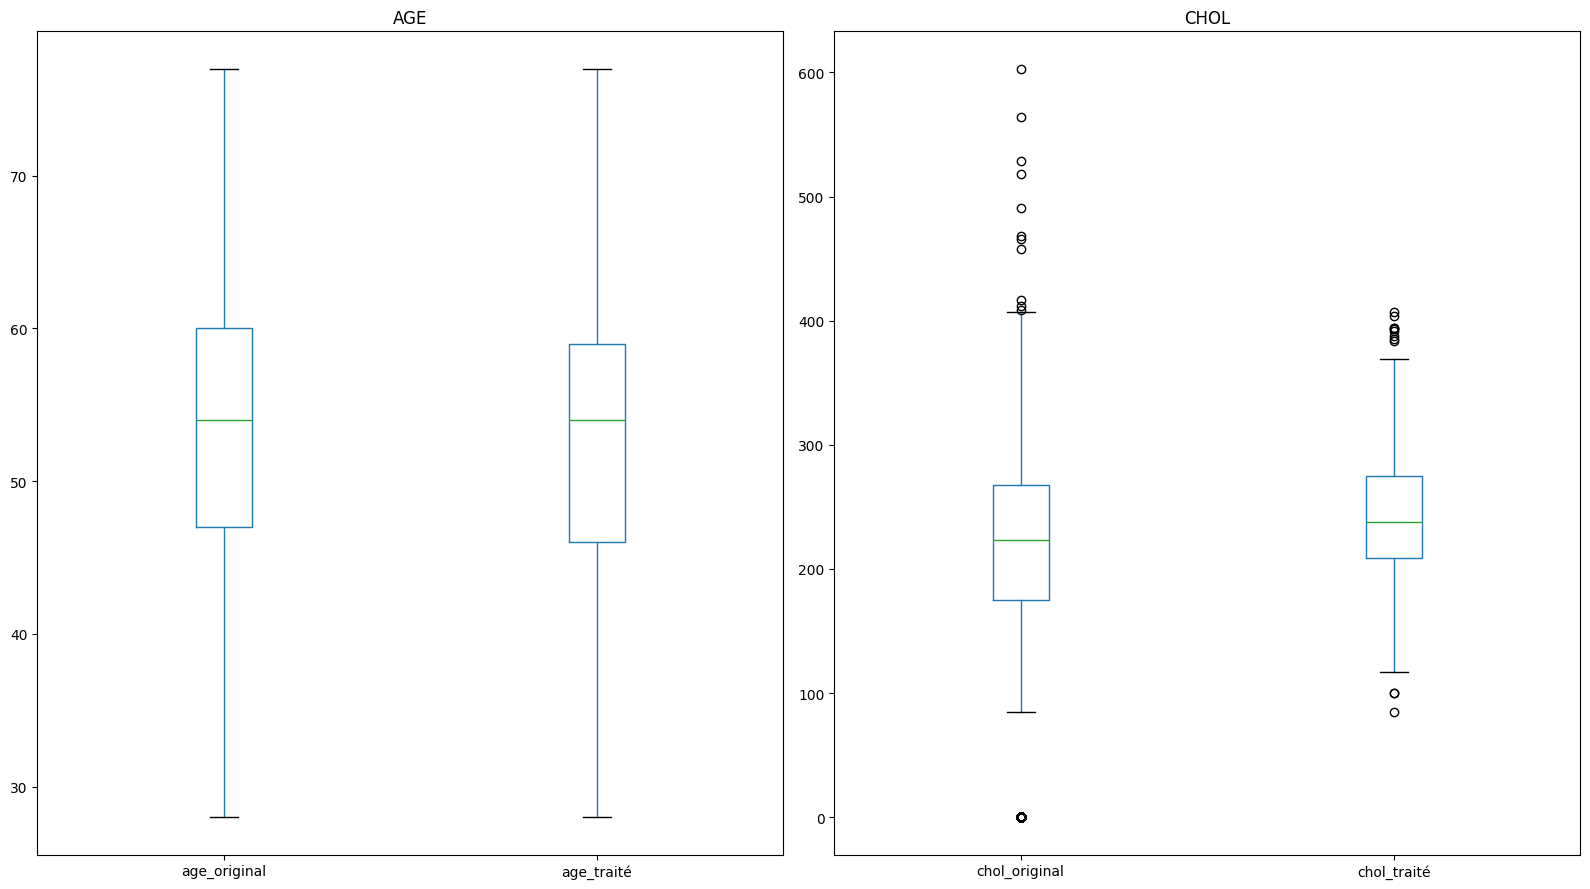

In [ ]:
# 2.2.1 ************************************************************************
#Création d’un dataframe
spark = SparkSession.builder.appName("SCI 1402 | Projet synthèse").getOrCreate()# (Chikhaoui, 2025)

# Suppression du dossier inutile
!rm -rf sample_data/

# ajout du jeu de données heart_disease_uci
# Création des dossiers donnees/csv et ajout de la base de données UCI
print("# 2.2.1.1")
# Pour respecter la règle verticale, l'url a été scinder en deux
e0="https://raw.githubusercontent.com/thiffaultg-teluq/sci1402/refs/heads/"     # (askubuntu, 28 septembre 2013)
e1="feature/sci1402_thiffaultg/Donn%C3%A9es/Brutes/heart_disease_uci.csv"
url=e0+e1

!wget -N -P donnees/csv/ $url

# 2.3.1 ************************************************************************
## 1. Traitement des données manquantes : **************************************
print("# 2.2.1.2")
uci="donnees/csv/heart_disease_uci.csv"
df = spark.read.options(header='true', inferSchema='true').csv(uci)
# Fonction permettant la suppression des colonnes vides pour les variables : age
# et chol
df_apres_supp = df.na.drop(subset=["age", "chol"])                              # (Sparkbyexamples, 25 septembre 2024)
# Vérification avant/après
print("  Avant:", df.count())
print("  Après:", df_apres_supp.count())

## 2. Traitement des données aberrantes ****************************************
### AGE ************************************************************************
def iqr_outlier_treatment(df, columns=["age"], factor=1.5):                     # (Machinelearningplus, 2025)
  # iqr_outlier_treatment => Fonction permettant de détecter et de traiter les
  # données aberrantes automatiquement
    for column in columns:
        quantiles = df_apres_supp.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        print("# 2.3.1.2 AGE")
        print("  Lower : ", lower_bound)
        print("  Upper : ", upper_bound)
        df = df.filter((col(column) >= lower_bound) & (col(column) <=
        upper_bound))
    return df
df_fiable = iqr_outlier_treatment(df_apres_supp)

print("  Nombre de rangées non-vides : " + str(df_fiable.count()))              # (Stackoverflow, 9 juillet 2025)

### CHOL ***********************************************************************
def iqr_outlier_treatment(df, columns=["chol"], factor=1.5):
    for column in columns:
        quantiles = df_apres_supp.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        print("# 2.3.1.2 CHOL")
        print("  Lower : ", lower_bound)
        print("  Upper : ", upper_bound)
        df = df.filter((col(column) >= lower_bound) & (col(column) <=
        upper_bound))
    return df
df_fiable = iqr_outlier_treatment(df_apres_supp)
print("  Nombre de rangées non-vides : " + str(df_fiable.count()))

## Diagramme à moustache *******************************************************
### AGE ************************************************************************
pdDF = df_apres_supp.toPandas()                                                 # (Machinelearningplus, 2025)
df_modifie = df_fiable.toPandas()                                               # (Geeksforgeeks, 2 janvier 2025)
                                                                                # (Pandas, 2024)
df_age = pd.DataFrame({
    'age_original': pdDF['age'],
    'age_traité': df_modifie['age'],
})

### CHOL ***********************************************************************
df_chol = pd.DataFrame({
    'chol_original': pdDF['chol'],
    'chol_traité': df_modifie['chol']
})

#*******************************************************************************

# Affichage des diagrammes à moustache, dans la même image,
fig, axes = plt.subplots(1,2, figsize=(16, 9)) # (nombre de rangées : 1,        # (Stackoverflow, 1 février 2020)
# nombre de colonnes: 2, grandeur de l'image : ratio 16/9 )

## -AGE
df_age.boxplot(column=['age_original', 'age_traité'], ax=axes[0], grid=False
).set(title='AGE') # Ajout du titre "AGE"                                       # (geeksforgeeks, 2024)

#*****

## -CHOL
df_chol.boxplot(column=['chol_original', 'chol_traité'], ax=axes[1],
grid=False).set(title='CHOL')

plt.tight_layout() # Permet d'ajuster les diagrammes à la zone                  # (geeksforgeeks, 2024)
plt.show()  # Permet d'afficher le ou les boxplots

# 2.3.2 Conversion des catégories en valeurs numériques ************************
#df_fiable.select("num").distinct().show()

## THAL ************************************************************************
df_fiable = df_fiable.withColumn(                                               # (Stackoverflow, 4 avril 2023)
    "thal",
    when(df_fiable.thal == "normal", 1)
    .when(df_fiable.thal == "fixed defect", 2)
    .when(df_fiable.thal == "reversable defect", 3)
    .otherwise(None)
)
## SEX *************************************************************************
df_fiable = df_fiable.withColumn(
    "sex",
    when(df_fiable.sex == "Female", 1)
    .when(df_fiable.sex == "Male", 2)
    .otherwise(None)
)
## DATASET *********************************************************************
df_fiable = df_fiable.withColumn(
    "dataset",
    when(df_fiable.dataset == "VA Long Beach", 1)
    .when(df_fiable.dataset == "Cleveland", 2)
    .when(df_fiable.dataset == "Hungary", 3)
    .otherwise(None)
)
## CP **************************************************************************
df_fiable = df_fiable.withColumn(
    "cp",
    when(df_fiable.cp == "asymptomatic", 1)
    .when(df_fiable.cp == "non-anginal", 2)
    .when(df_fiable.cp == "typical angina", 3)
    .when(df_fiable.cp == "atypical angina", 4)
    .otherwise(None)
)
## RESTECG *********************************************************************
df_fiable = df_fiable.withColumn(
    "restecg",
    when(df_fiable.restecg == "lv hypertrophy", 1)
    .when(df_fiable.restecg == "normal", 2)
    .when(df_fiable.restecg == "st-t abnormality", 3)
    .otherwise(None)
)
## SLOPE ***********************************************************************
df_fiable = df_fiable.withColumn(
    "slope",
    when(df_fiable.slope == "flat", 1)
    .when(df_fiable.slope == "downsloping", 2)
    .when(df_fiable.slope == "upsloping", 3)
    .otherwise(None)
)

# 3.Produit final et présentation

In [ ]:

# 3.1 Analyser et apprendre
## 3.1.1 Analyse partielle de lhypothèse de départ avec les données transformées

# Application des filtres
df_fiable_filtre = df_fiable.filter((col("age") >= 65) & (col("chol") > 200) &
 (col("num") >= 1))

#Création du fichier .csv avec un nom unique                                    # (Stackoverflow, 27 avril 2017)

TEMPORARY_TARGET="/content/donnees/csv/temp/donnees-filtrees"
DESIRED_TARGET="/content/donnees/csv/donnees-filtrees.csv"
df_fiable_filtre.coalesce(1).write.mode("overwrite").option("header", "true")\
.csv(TEMPORARY_TARGET)
part_filename = next(entry for entry in os.listdir(TEMPORARY_TARGET) if entry\
.startswith('part-'))
temporary_csv = os.path.join(TEMPORARY_TARGET, part_filename)

shutil.copyfile(temporary_csv, DESIRED_TARGET)

# 3.1.2 Étapes d’estimation en appliquant un algorithme d'apprentissage machine*
df_filtre = spark.read.csv("/content/donnees/csv/donnees-filtrees.csv", header=
True, inferSchema=True)

filtre_pd = df_filtre.toPandas()
# Paramètrage de KFOLD :
  #n_splits = 3 => Entrainement 2/3 | Test 1/3
kf = KFold(n_splits=3, shuffle=True, random_state=49)                           # (Geeksforgeeks, 27 mai 2024)

# Initiation des deux groupes :
for train_index, test_index in kf.split(filtre_pd):
  train_pd = filtre_pd.iloc[train_index]
  test_pd = filtre_pd.iloc[test_index]

# Charger les données d'entraînement
train_df = spark.createDataFrame(train_pd)
# Charger les données de test
test_df = spark.createDataFrame(test_pd)

# Préparer l'assembleur de vecteurs                                             # (Chikhaoui, 2025)
cols = ["age", "chol"]
assembler = VectorAssembler(inputCols=cols, outputCol="features")

# Appliquer l'assembleur de vecteurs
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Renommer la colonne de label
train_df = train_df.withColumnRenamed("num", "label")
test_df = test_df.withColumnRenamed("num", "label")

# Entraîner le modèle de classification par régression logistique
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
model = lr.fit(train_df)

# Faire des prédictions et évaluer le modèle
predictions = model.transform(test_df)

# 3.1.3 Calculer la précision du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol=
"prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("3.1.3| Précision")
print(f"  Précision: {accuracy}")

from sklearn.linear_model import LogisticRegression                             # (Medium, 4 novembre 2024)
# Variable indépendante (Feature)                                               # (Medium, 1 janvier 2023)
X = filtre_pd[["age", "chol", "cp"]]
# Variable dépendante (Target)
Y = filtre_pd["num"]
# MinMaxScaler => Permet de mettre à l'échelle selon une plage spécifique [0,1] # (Medium, 25 aout 2024)
scaler = MinMaxScaler()
# scaler.fit_transform(X) => Permet d'avoir les paramètres nécessaires et       # (Medium, 19 septembre 2024)
# d'apporter les transformations
XX = scaler.fit_transform(X)
# LogisticRegression => Permet de prédire des résultats discrets
clf = LogisticRegression(random_state=4)
# cross_val_score => Permet de simplifier le processus du calcul de la variation# (Medium, 13 décembre 2024)
# croisée
cv_scores = cross_val_score(clf, XX, Y, cv = 3) # cv = nombre de plis (FOLD)

print("3.1.4 | Variation croisée")
print('  Scores de validation croisée (3 plis) :', cv_scores)
print('  Précision moyenne :', np.mean(cv_scores))

TEMPORARY_TARGET="/content/donnees/csv/temp/prediction"
DESIRED_TARGET="/content/donnees/csv/prediction.csv"

predictions.select("id","sex","dataset","chol","age","restecg","cp","label",\
"prediction").coalesce(1).write.mode("overwrite").option("header", "true")\
.csv(TEMPORARY_TARGET)

part_filename = next(entry for entry in os.listdir(TEMPORARY_TARGET) if entry\
.startswith('part-'))
temporary_csv = os.path.join(TEMPORARY_TARGET, part_filename)

shutil.copyfile(temporary_csv, DESIRED_TARGET)

3.1.3| Précision
  Précision: 0.42857142857142855
3.1.4 | Variation croisée
  Scores de validation croisée (3 plis) : [0.4        0.46666667 0.42857143]
  Précision moyenne : 0.43174603174603177


'/content/donnees/csv/prediction.csv'

# Bibliographie

askubuntu. (2013, 28 septembre). How to pass url as variable to wget..?. Repéré le 2 juin 2025 à https://askubuntu.com/questions/351093/how-to-pass-url-as-variable-to-wget

Chikhaoui, B. (2025). Module 3 | Spark [Notes fournies dans le cours SCI 1017]. SCI 1017 vm3: Section 3.4 | TELUQ

Geekforgeeks (2024, 1 aout). OS Module in Python with Examples. Repéré le 30 mai 2025 à https://www.geeksforgeeks.org/os-module-python-examples/

Geekforgeeks (2024, 23 décembre). Matplotlib.pyplot.tight_layout() in Python. Repéré le 29 mai 2025 à https://www.geeksforgeeks.org/matplotlib-pyplot-tight_layout-in-python/

Geekforgeeks (2024, 26 mai). https://www.geeksforgeeks.org/shutil-module-in-python/. Repéré le 30 mai 2025 à https://www.geeksforgeeks.org/shutil-module-in-python/

Geekforgeeks (2024, 5 juillet). Matplotlib.pyplot.tight_layout() in Python. Repéré le 29 mai 2025 à https://www.geeksforgeeks.org/adding-titles-to-seaborn-boxplots/

Geeksforgeeks. (2024, 27 mai). Cross-Validation Using K-Fold With Scikit-Learn. Repéré le 10 mai 2025 à https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/

Geeksforgeeks. (2025, 2 janvier). Different ways to create Pandas Dataframe. Repéré le 4 mai 2025 à https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/

Machinelearningplus. (2025). PySpark Outlier Detection and Treatment – A Comprehensive Guide How to handle Outlier in PySpark. Repéré le 27 avril 2025 à https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/

Medium. (2023, 1 janvier). Logistic Regression for Feature Selection: Selecting the Right Features for Your Model. Repéré le 2 juin 2025 à https://medium.com/@rithpansanga/logistic-regression-for-feature-selection-selecting-the-right-features-for-your-model-410ca093c5e0

Medium. (2024, 13 décembre). Achieving Reliable Model Performance with cross_val_score. Repéré le 2 juin 2025 à https://medium.com/@abhaysingh71711/achieving-reliable-model-performance-with-cross-val-score-52c29e31fa6e

Medium. (2024, 19 septembre). Difference between fit(), transform(), and fit_transform() in Scikit-Learn. Repéré le 2 juin 2025 à https://medium.com/think-ai/difference-between-fit-transform-and-fit-transform-in-scikit-learn-5a614426fe71

Medium. (2024, 25 aout). How Min-Max Scaler Works. Repéré le 2 juin 2025 à https://medium.com/@iamkamleshrangi/how-min-max-scaler-works-9fbebb9347da

Medium. (2024, 4 novembre). Cross Validation with Code Examples. Repéré le 14 mai 2025 à https://xinqianzhai.medium.com/cross-validation-with-code-examples-eaabc440f61d

Spark.apache. (2025). pyspark.sql.functions.when. Repéré le 2 juin 2025 à https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.when.html

Sparkbyexamples. (2024, 25 septembre). PySpark Drop Rows with NULL or None Values. Repéré le 27 avril 2025 à https://sparkbyexamples.com/pyspark/pyspark-drop-rows-with-null-values/#:~:text=In%20order%20to%20remove%20Rows,NULL%20values%20to%20delete%20rows

Sparkreference. (2025). Introduction to the col() function. Repéré le 2 juin 2025 à https://www.sparkreference.com/reference/col/#:~:text=The%20col()%20function%20in,specific%20column%20of%20your%20DataFrame.

Stackoverflow. (2020, 1 février). Draw subplots boxplot using python. Repéré le 29 mai 2025  à https://stackoverflow.com/questions/60015020/draw-subplots-boxplot-using-python

Stackoverflow. (2017, 27 avril). Spark - How to write a single csv file WITHOUT folder?. Repéré le 8 mai 2025  à https://stackoverflow.com/questions/43661660/spark-how-to-write-a-single-csv-file-without-folder
Stackoverflow. (2018, 9 juillet). How to resolve TypeError: can only concatenate str (not "int") to str [duplicate]. Repéré le 29 mai 2025  à https://stackoverflow.com/questions/51252580/how-to-resolve-typeerror-can-only-concatenate-str-not-int-to-str

Stackoverflow. (2023, 4 avril). Pyspark Dataframe - Map Strings to Numerics. Repéré le 8 mai 2025  à https://stackoverflow.com/questions/47577758/pyspark-dataframe-map-strings-to-numerics

W3schools. (2025). NumPy Introduction. Repéré le 2 juin 2025 à https://www.w3schools.com/python/numpy/numpy_intro.asp



